# Wavelet Attribution Method (WAM) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/wam/blob/main/wam_example.ipynb)

This notebook shows how to use the Wavelet Attribution Method (WAM) to visualize what scales matter most to a model's predictions. For the full technical details, check out [our paper](https://openreview.net/forum?id=njZ5oVPObS) or the [project repository](https://github.com/gabrielkasmi/wam).

In [1]:
# If you run this notebook locally, ignore this cell
# and directly import the libraries

# Clone the WAM repository
!git clone https://github.com/gabrielkasmi/wam.git
%cd wam

# Install required packages from requirements.txt
!pip install -r requirements.txt

Cloning into 'wam'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 383 (delta 34), reused 69 (delta 21), pack-reused 294 (from 1)
Receiving objects: 100% (383/383), 44.60 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/wam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 6.2 MB/s eta 0:00:00


In [2]:
# Libraries imports
from torchvision import transforms, models
import torch
from lib.wam_2D import WaveletAttribution2D
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.viewers import plot_wam

In [14]:
# Set up the model and the explainer

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

transform = transforms.Compose([
    transforms.Resize(280),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# parameters for the explainer
wavelet="haar"
levels=3
method="smooth" # choose between "integratedgrad" or "smooth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

explainer = WaveletAttribution2D(model,
                                 wavelet=wavelet,
                                 J=levels,
                                 method=method,
                                 mode="reflect",
                                 )

In [4]:
# x2 = transform(Image.open("/content/n1.jpg")).unsqueeze(0)
# y2 = model(x2.to(device)).argmax().item()

In [5]:
# x.shape
# x2.shape

In [15]:
def get_explanations_for_image_folder(image_folder_path, model, explainer, transform, device, J):

  Y = []
  X = torch.empty(0, 3, 224, 224)
  images = []
  for file in os.listdir(image_folder_path):
    if file.endswith(".jpg"):
      image_path = os.path.join(image_folder_path, file)
      x = transform(Image.open(image_path)).unsqueeze(0)
      y = model(x.to(device)).argmax().item()
      Y.append(y)
      images.append(x)
      X = torch.cat((X, x), dim=0)
  explanations = explainer(X, Y)
  # print(explanations.shape
  return explanations, images



In [7]:
import os

In [16]:
new_explanations, new_images = get_explanations_for_image_folder("/content/obrazki_testowe", model, explainer, transform, device, levels)

In [ ]:
# # load the image
# x=transform(Image.open("assets/elephant.jpg")).unsqueeze(0)
# y=model(x.to(device)).argmax().item()
# ##stack x and x2 into sth of shape (2,C,W,H)
# x=torch.cat((x,x2),dim=0)
# print(x.shape)
# y = [y,y2]
# print(y[0])
# # compute the explanations
# explantions=explainer(x,y)

# # display the results
# # Create a figure with two subplots side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Plot original image on the left
# # Convert tensor back to image format and denormalize
# img = x[1].squeeze(0).permute(1,2,0).numpy()
# img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
# img = np.clip(img, 0, 1)
# ax1.imshow(img)
# ax1.set_title('Original Image')
# ax1.axis('off')

# # Plot WAM on the right using the provided plot_wam function
# plot_wam(ax2, explantions[1], levels=levels, cmap='viridis', smooth=True)
# ax2.set_title('WAM')
# ax2.axis('off')

# plt.tight_layout()
# plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_explanations_basic(
    explanations,
    images,
    levels,
    cmap='viridis',
    smooth=True,
    which=0
):
    """
    Visualizes original images and corresponding explanations (WAM).

    Parameters:
    - explanations : list or tensor of explanation maps
    - images       : tensor of images (N, C, H, W)
    - levels       : contour levels for plot_wam
    - cmap         : colormap
    - smooth       : whether to smooth WAM
    - which        : index of image to show or 'all'
    """

    if which == 'all':
        indices = range(len(explanations))
    else:
        if which < 0 or which >= len(explanations):
            raise IndexError("Parameter 'which' is out of range.")
        indices = [which]

    for i in indices:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # --- Original image ---
        img = images[i].squeeze(0).permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # --- WAM ---
        plot_wam(
            ax2,
            explanations[i],
            levels=levels,
            cmap=cmap,
            smooth=smooth
        )
        ax2.set_title('WAM')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

    return None


In [18]:
visualize_explanations_basic(new_explanations, new_images, levels, which = 'all')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
def get_diagonal(grad_wam, J):
    """
    Wyodrębnia diagonalne bloki WAM:
    - level_0 ... level_{J-1}  (szczegóły, od najdrobniejszych)
    - approx                  (najgrubsza skala)

    Zwraca:
    dict[str, np.ndarray]
    """
    H, W = grad_wam.shape
    assert H == W, "grad_wam must be square"

    diagonals = {}

    for j in range(J):
        start = H // (2 ** (j + 1))
        end = H // (2 ** j)
        diagonals[f"level_{j}"] = grad_wam[start:end, start:end]

    approx_size = H // (2 ** J)
    diagonals["approx"] = grad_wam[:approx_size, :approx_size]

    return diagonals


In [20]:
def plot_diagonal(diagonals, cmap="viridis", figsize=(14, 4)):
    """
    Rysuje wszystkie poziomy diagonalne + approx obok siebie
    """
    keys = list(diagonals.keys())
    n = len(keys)

    fig, axes = plt.subplots(1, n, figsize=figsize)

    for i, key in enumerate(keys):
        ax = axes[i] if n > 1 else axes
        im = ax.imshow(diagonals[key], cmap=cmap)
        ax.set_title(key)
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    return fig


In [21]:
def get_mean_pixelwise_variance(grad_wam, J, size="maximal"):
    """
    Liczy pixel-wise wariancję pomiędzy poziomami szczegółów.

    Parametry:
    - grad_wam : 2D ndarray
    - J        : liczba poziomów
    - size     : "maximal" | "minimal"
        - maximal -> skaluj do największego poziomu
        - minimal -> skaluj do najmniejszego poziomu

    Zwraca:
    - mean_variance : float
    - variance_map  : 2D ndarray
    """
    diagonals = get_diagonal(grad_wam, J)

    # tylko szczegóły
    detail_levels = [diagonals[f"level_{j}"] for j in range(J)]

    sizes = [lvl.shape[0] for lvl in detail_levels]

    if size == "maximal":
        target_size = max(sizes)
    elif size == "minimal":
        target_size = min(sizes)
    else:
        raise ValueError("size must be 'maximal' or 'minimal'")

    resized = []
    for lvl in detail_levels:
        scale = target_size / lvl.shape[0]
        lvl_resized = zoom(lvl, scale, order=1)
        resized.append(lvl_resized[:target_size, :target_size])

    stack = np.stack(resized, axis=0)   # (J, H, W)

    variance_map = np.var(stack, axis=0)
    mean_variance = float(np.mean(variance_map))

    return mean_variance, variance_map


In [22]:
def rank_images(explanations, J, size="maximal"):
    """
    Rankuje obrazy według cross-level pixel-wise wariancji.

    Zwraca:
    lista słowników:
    [
        {
            "image_index": int,
            "mean_pixelwise_variance": float
        },
        ...
    ]
    """
    ranking = []

    for idx, grad_wam in enumerate(explanations):
        mean_var, _ = get_mean_pixelwise_variance(
            grad_wam, J, size=size
        )
        ranking.append({
            "image_index": idx,
            "mean_pixelwise_variance": mean_var
        })

    ranking.sort(
        key=lambda x: x["mean_pixelwise_variance"],
        reverse=True
    )

    return ranking


In [24]:
#import zoom
from scipy.ndimage import zoom

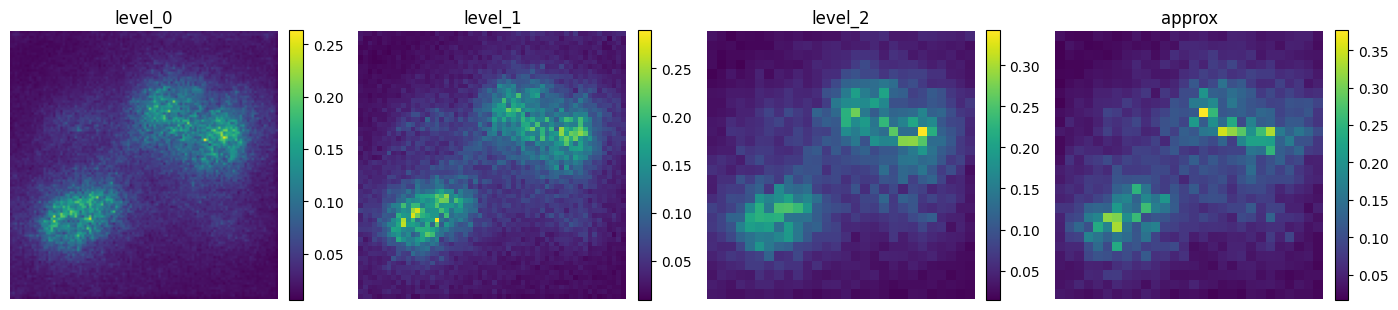

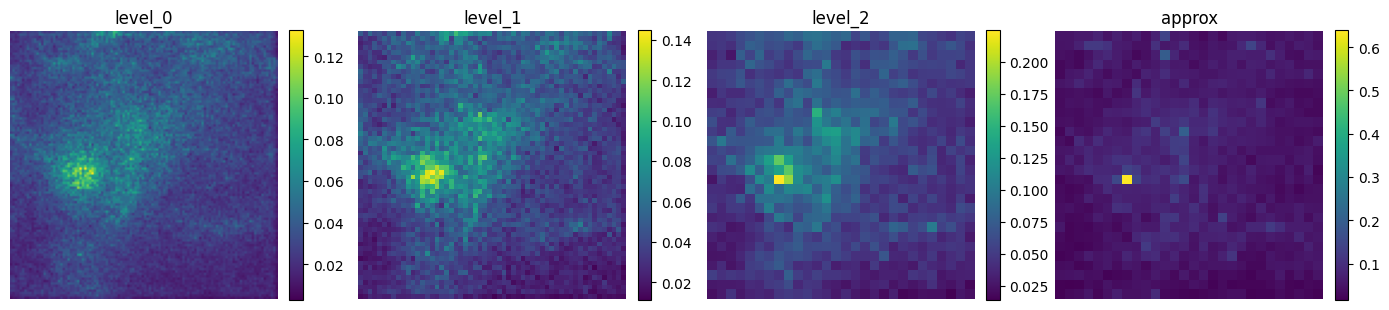

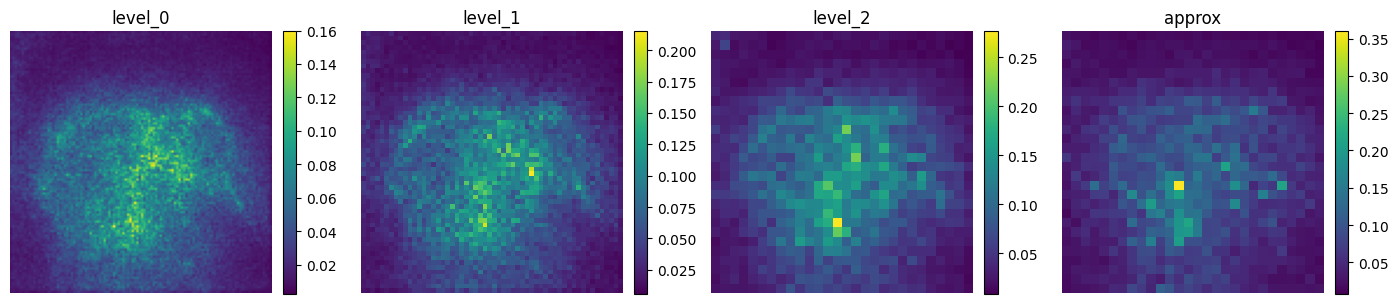

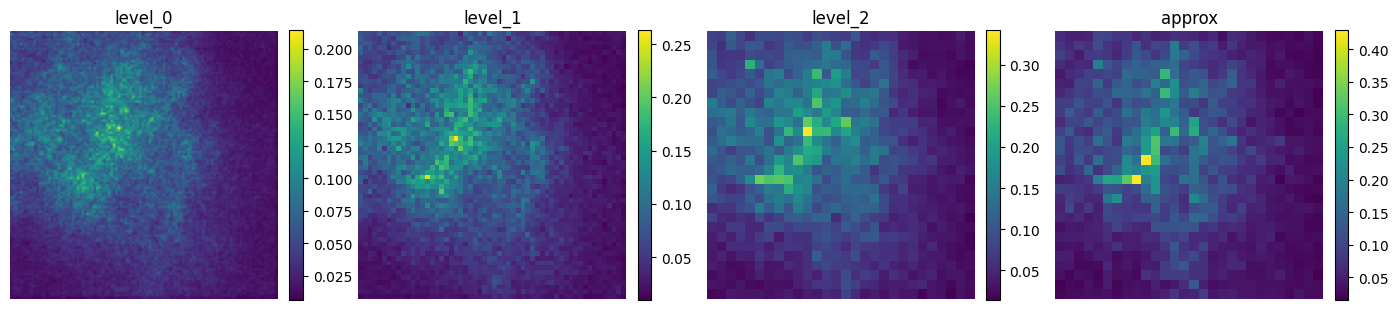

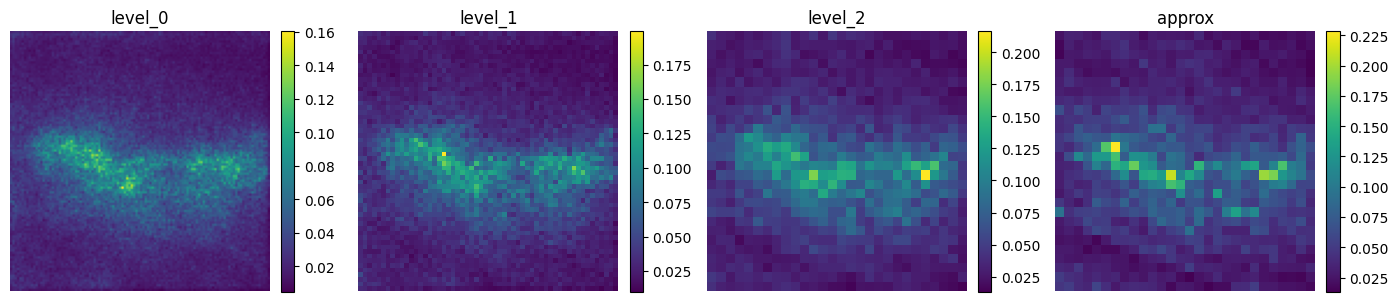

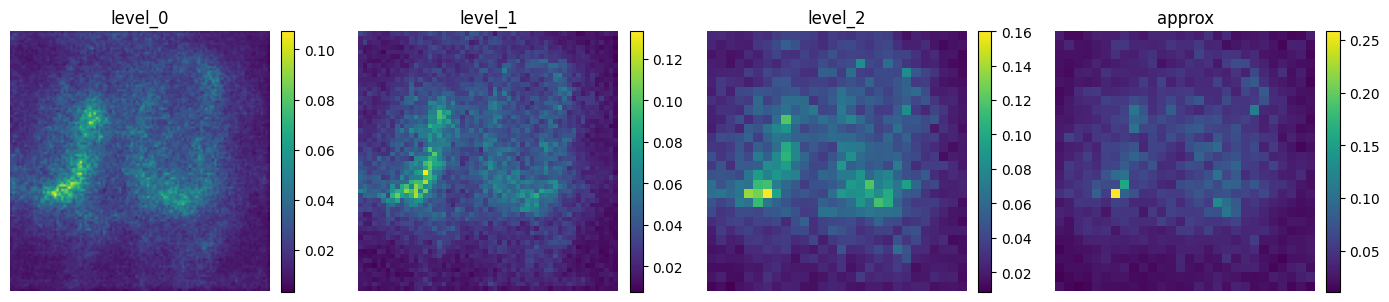

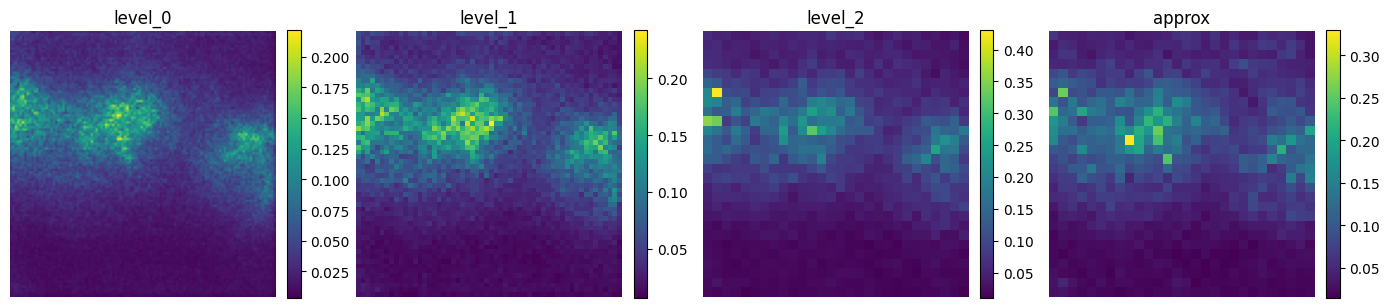

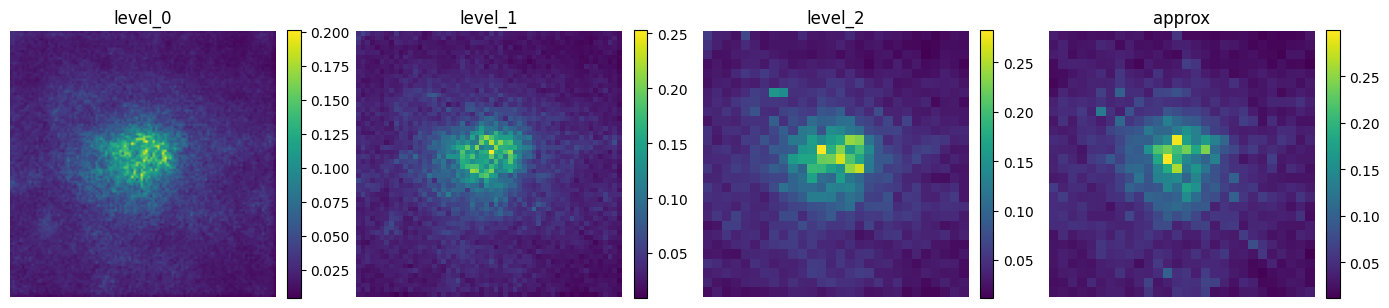

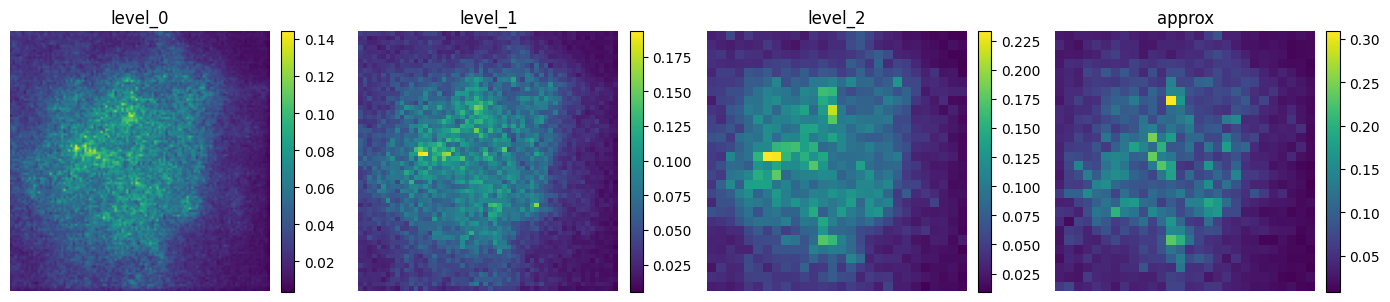

Mean pixel-wise variance: 0.000154


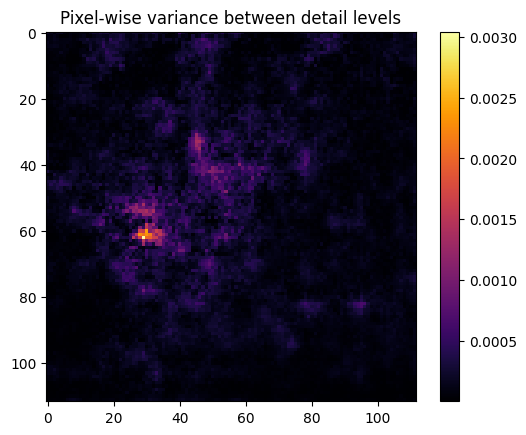

Top 5 images by variance:
{'image_index': 3, 'mean_pixelwise_variance': 0.00037786032450857853}
{'image_index': 6, 'mean_pixelwise_variance': 0.0002475734720989376}
{'image_index': 0, 'mean_pixelwise_variance': 0.0002420755388852035}
{'image_index': 2, 'mean_pixelwise_variance': 0.00019776265062883624}
{'image_index': 8, 'mean_pixelwise_variance': 0.00019700896099775407}


In [25]:
J = levels
idx = 1
for i in range(9):
# 1. Diagonale
  diagonals = get_diagonal(new_explanations[i], J)
  plot_diagonal(diagonals)
  plt.show()

# 2. Wariancja
mean_var, var_map = get_mean_pixelwise_variance(
    new_explanations[idx], J, size="maximal"
)

print(f"Mean pixel-wise variance: {mean_var:.6f}")

plt.imshow(var_map, cmap="inferno")
plt.title("Pixel-wise variance between detail levels")
plt.colorbar()
plt.show()

# 3. Ranking
ranking = rank_images(new_explanations, J, size="maximal")

print("Top 5 images by variance:")
for r in ranking[:5]:
    print(r)
